<a href="https://colab.research.google.com/github/Slugabed/Erlang_hw/blob/master/sirius_surveys_demo_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Скачиваем данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/My Drive/sirius/token.txt' token.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !sudo apt-get install git-lfs
with open('token.txt', 'r') as f:
  auth_token = f.read()
print(auth_token)
!git lfs clone https://{auth_token}@github.com/xechehot/sirius-survey-data.git
!git clone https://{auth_token}@github.com/xechehot/ordalium.git
!find ./sirius-survey-data -name '*.tar.gz' -exec tar -xzvf '{}' \;

In [ ]:
!find ./ordalium -name '*.tar.gz' -exec tar -xzvf '{}' \;

banners.csv
questions.csv


In [ ]:
!cp ordalium/common.py common.py

Читаем данные

In [1]:
import pandas as pd
import numpy as np
from common import load_csv, normalize_events, make_question_table

# !pip install pandas jupyter pandarallel tqdm

# from tqdm import tqdm
# tqdm.pandas()
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True, nb_workers=2)

In [2]:
df_surveys, df_events, df_orders, df_revisions = load_csv()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
banners_mask = df_events['campaign_type'] == 'banner' & (df_events.action_code == 1)
video_mask = df_events['campaign_type'] == 'video' & (df_events.action_code == 1)
toloka_mask = df_events['campaign_type'].isnull() & (df_events.action_code == 1)

# extract banner interviews
banner_survey_ids = df_events[banners_mask].index.get_level_values(0).unique()
banner_interview_ids = df_events[banners_mask].index.get_level_values(1).unique()
banners = df_events[df_events.index.get_level_values(0).isin(banner_survey_ids) \
            & df_events.index.get_level_values(1).isin(banner_interview_ids)]

# extract videos
video_survey_ids = df_events[video_mask].index.get_level_values(0).unique()
video_interview_ids = df_events[video_mask].index.get_level_values(1).unique()
videos = df_events[df_events.index.get_level_values(0).isin(video_survey_ids) \
        & df_events.index.get_level_values(1).isin(video_interview_ids)]

# normalize videos
# videos_normalized = normalize_ts(videos)
# videos_normalized.to_csv('/content/drive/My Drive/sirius/videos.csv')


#read normalized banners
# banners = banners.reset_index().set_index(['survey_id', 'interview_id']).sort_values('ts')
#banners_normalized = normalize_ts(banners)
#banners_normalized.to_csv('/content/drive/My Drive/sirius/banners_4.csv')
banners_normalized = pd.read_csv('banners.csv')
banners_normalized['survey_id'] = banners_normalized['survey_id'].astype(np.uint64)
banners_normalized = banners_normalized.reset_index().set_index(['survey_id', 'revision_id', 'question_id'])
banners_normalized.index.set_levels([banners_normalized.index.levels[0].astype(int),
                                                    banners_normalized.index.levels[1],
                                                    banners_normalized.index.levels[2].astype(int)])
banners_normalized_questions = banners_normalized.loc[~banners_normalized.index.get_level_values(2).isnull()]

# questions
# df_questions = df_revisions.groupby(['survey_id', 'revision_id']).apply(make_question_table)
# df_questions.to_csv('/content/drive/My Drive/sirius/df_questions.csv')
df_questions = pd.read_csv('questions.csv')
df_questions = df_questions.reset_index(drop=True).set_index(['survey_id', 'revision_id', 'question_id'])

# events expanded
df_events_expanded = banners_normalized_questions.merge(df_questions, how='inner', left_index=True, right_index=True)

video_events_expanded = pd.read_csv('video_events_expanded.csv') \
        .reset_index(drop=True).set_index(['survey_id',	'revision_id',	'interview_id'])

In [50]:
entropy_videos = videos_4_answers_2.apply(lambda j: sum([x*np.log(x/sum(j.values()))/sum(j.values()) for x in j.values()]))
entropy_banners = question_answers.apply(lambda j: sum([x*np.log(x/sum(j.values()))/sum(j.values()) for x in j.values()]))

(array([  7.,   6.,   9.,   4.,  17., 131., 143., 166., 173., 254., 241.,
        207., 315., 250., 206., 228., 291., 217., 146.,  91., 191., 276.,
        154., 108.,  74.,  37.,  34.,  13.,   4., 220.]),
 array([-2.29074444, -2.21438629, -2.13802815, -2.06167   , -1.98531185,
        -1.9089537 , -1.83259555, -1.75623741, -1.67987926, -1.60352111,
        -1.52716296, -1.45080481, -1.37444667, -1.29808852, -1.22173037,
        -1.14537222, -1.06901407, -0.99265592, -0.91629778, -0.83993963,
        -0.76358148, -0.68722333, -0.61086518, -0.53450704, -0.45814889,
        -0.38179074, -0.30543259, -0.22907444, -0.1527163 , -0.07635815,
         0.        ]),
 <a list of 30 Patch objects>)

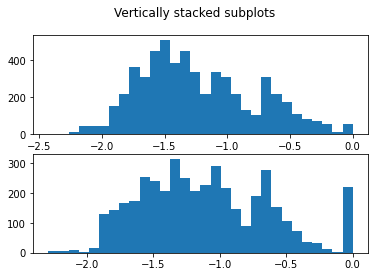

In [54]:
fig, axs = plt.subplots(2)
axs[0].hist(entropy_videos, bins=30, label='video')
axs[1].hist(entropy_banners, bins=30)

Подсчет выбранных вариантов ответов.

In [26]:
from collections import defaultdict
from collections.abc import Iterable
from matplotlib import pyplot as plt


def inc_dict(df, d, name):
  if df is np.nan:
    return
  for i in df:
    d[i] += 1


def calc_responses(df):
  result = defaultdict(lambda: 0)
  df.option_ids.str.split(',').apply(inc_dict, args=(result, df.name))
  return result

# question_answers = df_events_expanded.groupby(['survey_id', 'revision_id', 'question_id']).apply(calc_responses)

Дальше мои черновые наброски, не смотреть)

In [ ]:
df_events_expanded[df_events_expanded.interview_id == 11262651416569394865].loc[(70075, 1,)].option_ids.str.split(',')

question_id
1.0    [2, 5]
2.0      [11]
3.0      [17]
4.0      [23]
Name: option_ids, dtype: object

In [49]:
from collections import defaultdict
from collections.abc import Iterable
from matplotlib import pyplot as plt


def inc_dict(df, d, name):
  if df is np.nan:
    return
  for i in df:
    d[i] += 1


def calc_responses(df):
  result = defaultdict(lambda: 0)
  df.option_ids.str.split(',').apply(inc_dict, args=(result, df.name))
  return result

question_answers = df_events_expanded.groupby(['survey_id', 'revision_id', 'question_id']).apply(calc_responses)

(array([1., 0., 0., 1., 0., 0., 1., 0., 2., 1.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <a list of 10 Patch objects>)

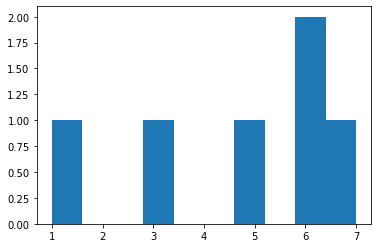

In [ ]:
some_answers = question_answers.loc[(70048, 3, 6.0)]
plt.hist(some_answers.values(), label=some_answers.keys())


In [ ]:
entropy = question_answers.apply(lambda j: sum([x*np.log(x/sum(j.values()))/sum(j.values()) for x in j.values()]))

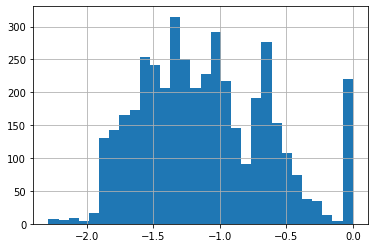

In [ ]:
entropy.hist(bins=30, label='Entropy')

In [ ]:
# entropy 
sum_ = sum(some_answers.values())
sum([x*np.log(x/sum_)/sum_ for x in some_answers.values()])

-1.672721970807394

In [ ]:
some_answers

defaultdict(<function __main__.calc_responses.<locals>.<lambda>>,
            {'-3': 6, '32': 5, '33': 6, '34': 1, '35': 3, '36': 7})

In [ ]:
import json

list(map(lambda x: int(x['id']), json.loads(df_revisions[df_revisions.survey_id == 39220].iloc[-1].str_questions)['1']['options']))

[1, 2]

In [ ]:
# extract videos
video_survey_ids = df_events[video_mask].index.get_level_values(0).unique()
video_interview_ids = df_events[video_mask]['interview_id'].unique()
videos = df_events[df_events.index.get_level_values(0).isin(video_survey_ids) & df_events['interview_id'].isin(video_interview_ids)]

# normalize videos
# videos_normalized = normalize_events(videos)
# videos_normalized.to_csv('/content/drive/My Drive/sirius/videos.csv')

KeyError: ignored

In [ ]:
videos.loc[[(39106, 218590411960607104, 1)]]

action_code  ...                ts
survey_id interview_id       revision_id               ...                  
39106     218590411960607104 1                      2  ...  1592575790011000
                             1                      3  ...  1592575791327000
                             1                      2  ...  1592575791327000
                             1                      1  ...  1592575781920000

[4 rows x 9 columns]

In [ ]:
import random
idxs = random.sample(range(banners_normalized.shape[0]), 150000)
b_ = banners_normalized.iloc[idxs].merge(df_questions, how='inner', left_index=True, right_index=True)

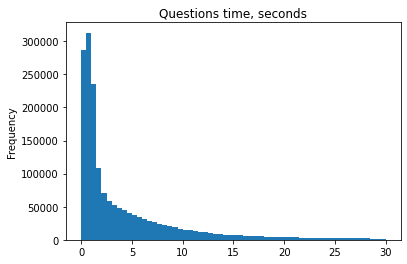

In [ ]:
(banners_normalized_.query('intervals < 30000000')['intervals'] /10**6).plot.hist(bins=60, title='Questions time, seconds')

In [ ]:
(df_events_expanded[df_events_expanded['intervals'] >= 5330000000]['intervals'] /10**6).plot.hist(bins=60, title='Questions time, seconds')

In [ ]:
banners_normalized

index  ...  intervals
survey_id revision_id question_id           ...           
39220     8           NaN                0  ...          0
                      1.0                1  ...    8363000
                      NaN                2  ...     812000
                      NaN                3  ...          0
                      NaN                4  ...          0
...                                    ...  ...        ...
69590     3           NaN          1880329  ...     772000
                      3.0          1880330  ...    6774000
                      NaN          1880331  ...    1060000
                      4.0          1880332  ...    3616000
                      NaN          1880333  ...     779000

[1880334 rows x 11 columns]

___

In [ ]:
(df_events['campaign_type'] == 'video').sum(), (df_events['campaign_type'] == 'banner').sum(),\
(df_events['campaign_type'].isnull()).sum()

(1135703, 604601, 15627281)

___

#@Анализ данных

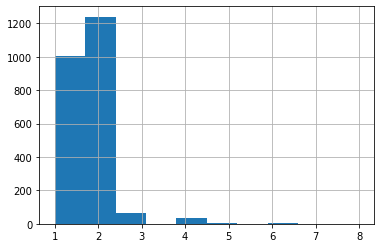

In [ ]:
df_orders.groupby(['survey_id', 'supplier_id']).size().hist()

In [ ]:
df_events_['campaign_type'].unique()

array([nan, 'video', 'banner'], dtype=object)

In [ ]:
df_events

,action_code,campaign_type,interview_id,option_ids,page_from,page_to,question_answer_text,question_id,revision_id,seq_num,survey_id,ts
0,2,NaN,229702692780707224,20,<NA>,<NA>,<NA>,9,2,20,33073,1576770102414000
1,2,NaN,229702692780707224,107,<NA>,<NA>,<NA>,20,2,25,33073,1576770222923000
2,1,NaN,229702692780707224,<NA>,<NA>,<NA>,<NA>,<NA>,2,1,33073,1576769716990000
3,2,NaN,229702692780707224,<NA>,<NA>,<NA>,40,1,2,25,33073,1576770222923000
4,2,NaN,229702692780707224,1,<NA>,<NA>,<NA>,2,2,25,33073,1576770222923000
...,...,...,...,...,...,...,...,...,...,...,...,...
17367580,1,banner,11262651416569394865,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,70075,1593472880966000
17367581,4,NaN,11262651416569394865,<NA>,1,2,<NA>,<NA>,1,4,70075,1593472913191000
17367582,2,NaN,11262651416569394865,"2,5",<NA>,<NA>,<NA>,1,1,3,70075,1593472912007000
17367583,2,NaN,11262651416569394865,2,<NA>,<NA>,<NA>,1,1,2,70075,1593472910894000


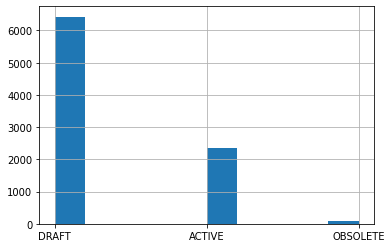

In [ ]:
df_revisions['revision_state'].hist()

___

In [ ]:
len(df_surveys['survey_id'].unique()), df_surveys.shape

(2361, (2361, 11))

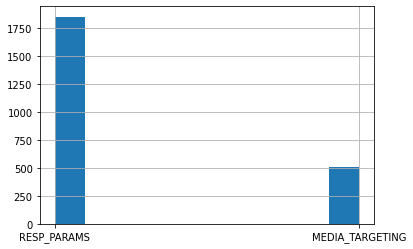

In [ ]:
df_surveys['audience_request_refined_type'].hist()

RESP_PARAMS - по демографии
MEDIA_TARGETING - по интересам

____

In [ ]:
for amount in [20000, 10000, 5000, 1000, 500, 400, 300, 200, 100, 50, 10]:
  print(f"Amount of surveys with audience less than {amount}: {(df_surveys['audience_request_size'] < amount).sum()}")

Amount of surveys with audience less than 20000: 2342
Amount of surveys with audience less than 10000: 2339
Amount of surveys with audience less than 5000: 2339
Amount of surveys with audience less than 1000: 2115
Amount of surveys with audience less than 500: 1940
Amount of surveys with audience less than 400: 1885
Amount of surveys with audience less than 300: 1655
Amount of surveys with audience less than 200: 1427
Amount of surveys with audience less than 100: 2
Amount of surveys with audience less than 50: 1
Amount of surveys with audience less than 10: 0


Охват аудитории от 200 до 500

___

In [ ]:
(df_surveys['box_name'].isnull()).sum(), (~ df_surveys['box_name'].isnull()).sum()

(592, 1769)

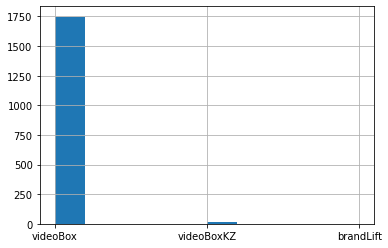

In [ ]:
df_surveys['box_name'].hist()

In [ ]:
for name in ['videoBox', 'videoBoxKZ', 'brandLift']:
  print(f"Boxname {name}: {(df_surveys['box_name'] ==name).sum()}")

Boxname videoBox: 1748
Boxname videoBoxKZ: 19
Boxname brandLift: 2


___

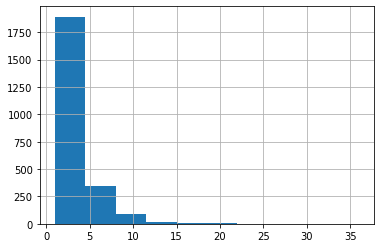

In [ ]:
df_surveys['revisions_count'].hist()

In [ ]:
(df_surveys['revisions_count'] > 11).sum()

37

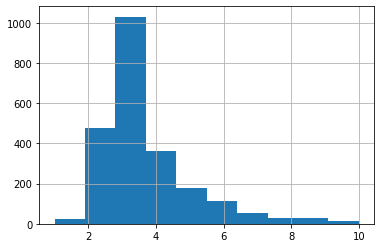

In [ ]:
df_surveys[df_surveys['revisions_count'] < 11]['revisions_count'].hist()

Наибольшее количество опросов с 2-5 ревизиями.
___

In [ ]:
df_surveys['targeting_age'].fillna('')

''

In [ ]:
pd.string

AttributeError: ignored

In [ ]:
for age in ['18_24','24_34','35_44','45_54','55_99']:
  print(f"Surveys with {age} age target: {(df_surveys['targeting_age'].str.contains(age)).sum()}")
print(f"Surveys with nan age target: {(df_surveys['targeting_age'].isnull()).sum()}")

Surveys with 18_24 age target: 998
Surveys with 24_34 age target: 1470
Surveys with 35_44 age target: 1449
Surveys with 45_54 age target: 1080
Surveys with 55_99 age target: 738
Surveys with nan age target: 591


In [ ]:
for target in range(1,6):
  print(f"Surveys with {target} age targets: {(df_surveys['targeting_age'].str.len() == (target*5 + (target-1)*1)).sum()}")

Surveys with 1 age targets: 317
Surveys with 2 age targets: 303
Surveys with 3 age targets: 356
Surveys with 4 age targets: 226
Surveys with 5 age targets: 568


In [ ]:

cnt = Counter()
cnt['alal'] = 2

___

In [ ]:
from collections import Counter
counter = Counter()
df_surveys['targeting_geo'][~df_surveys['targeting_geo'].isnull()].apply(lambda x: counter.update(x.split(',')))

In [ ]:
for key in counter.keys():
  print(f"Surveys with geo id {key}: {df_surveys['targeting_geo'].str.contains(key).sum()}")

Surveys with geo id 2: 1512
Surveys with geo id 213: 524
Surveys with geo id 225: 837
Surveys with geo id 29404: 5
Surveys with geo id 38: 61
Surveys with geo id 193: 61
Surveys with geo id 54: 100
Surveys with geo id 43: 89
Surveys with geo id 35: 77
Surveys with geo id 62: 53
Surveys with geo id 47: 72
Surveys with geo id 65: 71
Surveys with geo id 66: 52
Surveys with geo id 50: 63
Surveys with geo id 39: 69
Surveys with geo id 51: 66
Surveys with geo id 172: 62
Surveys with geo id 56: 67
Surveys with geo id 29403: 7
Surveys with geo id 29406: 8
Surveys with geo id 159: 4
Surveys with geo id 29417: 4
Surveys with geo id 29407: 4
Surveys with geo id 29408: 4
Surveys with geo id 29411: 4
Surveys with geo id 29412: 4
Surveys with geo id 29415: 4


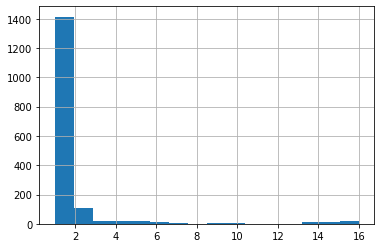

In [ ]:
(df_surveys['targeting_geo'][~df_surveys['targeting_geo'].isnull()].str.count(',') + 1).hist(bins=16)

In [ ]:
((df_surveys['targeting_geo'][~df_surveys['targeting_geo'].isnull()].str.count(',') + 1) > 8).sum(), \
((df_surveys['targeting_geo'][~df_surveys['targeting_geo'].isnull()].str.count(',') + 1) <= 1).sum(), \
((df_surveys['targeting_geo'][~df_surveys['targeting_geo'].isnull()].str.count(',') + 1) <= 2).sum(), \
((df_surveys['targeting_geo'][~df_surveys['targeting_geo'].isnull()].str.count(',') + 1) <= 8).sum()

(48, 1414, 1519, 1593)

В основном опросы охватывают один регион. Малая часть опросов охватывают несколько регионов.

_____________________________________

In [ ]:
df_surveys['targeting_gender'].isnull().sum()

1725

In [ ]:
(df_surveys['targeting_gender'] == 'f').sum(), (df_surveys['targeting_gender'] == 'm').sum()

(316, 320)

В целом опросы не направлены на конкретный пол. Оставшиеся поровну разделились между полами.
___

In [ ]:
for id in df_surveys['targeting_interest_id'].unique():
  print(f"Surveys with interest id {id}: {(df_surveys['targeting_interest_id']==id).sum()}")

Surveys with interest id <NA>: 0
Surveys with interest id 210: 33
Surveys with interest id 61: 9
Surveys with interest id 128: 21
Surveys with interest id 173: 86
Surveys with interest id 4: 22
Surveys with interest id 76: 21
Surveys with interest id 115: 34
Surveys with interest id 91: 28
Surveys with interest id 14: 25
Surveys with interest id 43: 12
Surveys with interest id 6: 5
Surveys with interest id 216: 9
Surveys with interest id 34: 31
Surveys with interest id 183: 41
Surveys with interest id 55: 9
Surveys with interest id 78: 27
Surveys with interest id 176: 3
Surveys with interest id 198: 4
Surveys with interest id 225: 10
Surveys with interest id 189: 5
Surveys with interest id 87: 7
Surveys with interest id 142: 3
Surveys with interest id 146: 3
Surveys with interest id 84: 6
Surveys with interest id 141: 3
Surveys with interest id 154: 2
Surveys with interest id 171: 5
Surveys with interest id 1: 10
Surveys with interest id 148: 2
Surveys with interest id 190: 1
Surveys w

___

In [ ]:
df_events.head()

,action_code,campaign_type,interview_id,option_ids,page_from,page_to,question_answer_text,question_id,revision_id,seq_num,survey_id,ts
0,2,NaN,2.297027e+17,20,NaN,NaN,NaN,9.0,2.0,20,33073,1576770102414000
1,2,NaN,2.297027e+17,107,NaN,NaN,NaN,20.0,2.0,25,33073,1576770222923000
2,1,NaN,2.297027e+17,NaN,NaN,NaN,NaN,NaN,2.0,1,33073,1576769716990000
3,2,NaN,2.297027e+17,NaN,NaN,NaN,40,1.0,2.0,25,33073,1576770222923000
4,2,NaN,2.297027e+17,1,NaN,NaN,NaN,2.0,2.0,25,33073,1576770222923000


In [ ]:
df_orders.head()

,campaign_type,supplier_id,supplier_order_created_at,supplier_order_updated_at,survey_id
0,NaN,1,1576753229,1576753230,33073
1,NaN,2,1567496013,1567496017,33931
2,NaN,2,1567519511,1567519514,33990
3,NaN,2,1567604801,1567604805,34070
4,NaN,2,1568277075,1568277077,34640


In [ ]:
df_revisions.head()

,Unnamed: 0,survey_id,revision_id,groups_count,activated_at,page_order,revision_state,groups,questions_count,created_at,widgets_count,resp_reuse,str_questions
0,0,33073,1,9,NaN,"[1.0, 2.0, 3.0, 5.0, 6.0, 8.0, 9.0, 10.0, 12.0]",DRAFT,"{""1"": {""children"": [{""id"": 1.0, ""type"": ""quest...",13,1566402470,2,NaN,"{""1"": {""id"": 1.0, ""label"": ""## Сколько вам лет..."
1,1,33073,2,9,1.576753e+09,"[1.0, 2.0, 3.0, 5.0, 6.0, 8.0, 9.0, 10.0, 12.0]",ACTIVE,"{""1"": {""children"": [{""id"": 1.0, ""type"": ""quest...",13,1576071425,2,NaN,"{""1"": {""id"": 1.0, ""label"": ""## Сколько вам лет..."
2,2,33073,3,9,NaN,"[1.0, 2.0, 3.0, 5.0, 6.0, 8.0, 9.0, 10.0, 12.0]",DRAFT,"{""1"": {""children"": [{""id"": 1.0, ""type"": ""quest...",13,1576752983,2,NaN,"{""1"": {""id"": 1.0, ""label"": ""## Сколько вам лет..."
3,3,33931,1,3,1.567496e+09,"[1.0, 2.0, 3.0]",ACTIVE,"{""1"": {""children"": [{""id"": 1.0, ""type"": ""widge...",6,1567495718,2,NaN,"{""10"": {""id"": 10.0, ""label"": ""Вопрос 10"", ""max..."
4,4,33931,2,3,NaN,"[1.0, 2.0, 3.0]",DRAFT,"{""1"": {""children"": [{""id"": 1.0, ""type"": ""widge...",6,1582622204,2,NaN,"{""10"": {""id"": 10.0, ""label"": ""Вопрос 10"", ""max..."


In [ ]:
df_revisions.iloc[0]['str_questions']

'{"1": {"id": 1.0, "label": "## Сколько вам лет?", "maxValue": 65.0, "minValue": 16.0, "required": true, "type": "number"}, "13": {"id": 13.0, "label": "Вопрос 13", "maxAnswerCount": 0.0, "multipleChoice": true, "noAnswer": {"enabled": false, "label": "Ничего из перечисленного"}, "noOpinionAnswer": {"enabled": false, "label": "Затрудняюсь ответить"}, "options": [{"id": 55.0, "label": "Вариант 55"}, {"id": 56.0, "label": "Вариант 56"}, {"id": 57.0, "label": "Вариант 57"}, {"id": 58.0, "label": "Вариант 58"}, {"id": 59.0, "label": "Вариант 59"}, {"id": 60.0, "label": "Вариант 60"}, {"id": 61.0, "label": "Вариант 61"}, {"id": 62.0, "label": "Вариант 62"}, {"id": 63.0, "label": "Вариант 63"}, {"id": 64.0, "label": "Вариант 64"}, {"id": 65.0, "label": "Вариант 65"}, {"id": 66.0, "label": "Вариант 66"}, {"id": 67.0, "label": "Вариант 67"}], "otherAnswer": {"enabled": false, "label": "Другое"}, "otherAnswerWithText": {"enabled": true, "label": "Другое (впишите свой вариант)"}, "required": tru

#@Теоретические мысли

X - случайная величина времени ответа пользователя и параметров вопроса. $z$ - ненаблюдаемой латентный вектор. $P(z|X)$ - апостерирорная вероятность латентной переменной, ненаблюдаемая величина. 

$Q(z|X) = N(z| \mu(X, \theta), \Sigma(X, \theta))$ - выучиваемое нами распределение, выдающую область наиболее вероятных латентных векторов z, которые порождают вектор X, $\mu(X, \theta), \Sigma(X, \theta)$ - нейросети. 

$P(X | z) = N(X|f(z;\theta), \sigma^2 \cdot I)$ - перекладываем сложность распределения на обучаемую функцию $f(z;\theta)$ - нейросеть.

$P(z) = N(0;I)$ - латетный вектор распределен нормально.

$$ \log P(X) - D_{KL} \left[ Q(z| X) || P(z|X)\right] = E_{z \sim Q}[\log P(X | z)] -D_{KL} \left[Q(z|X) || P(z) \right]$$

$$D_{KL}\left[N(\mu(X), \Sigma(X))|| N(0, I)\right] = \frac{1}{2}(tr(\Sigma(X)) +(\mu(X))^T(\mu(X)) -k - \log {det(\Sigma(X))})$$
Используя "трюк с параметризацией": $$z \sim \mu(X) + (\Sigma(X))^{\frac 1 2} \cdot \epsilon, \epsilon \sim N(0;I)$$

https://arxiv.org/pdf/1606.05908.pdf

In [ ]:
import keras, keras.layers as L
import keras.applications as zoo
from scipy.stats import multivariate_normal


z_dimension = 10
p_x_z_dimension = 10

def mu_nn(x):
  pass

def sigma_nn(x):
  pass

def sample_z(x):
  mu = mu_nn(x)
  sigma = sigma_nn(x)**0.5
  return mu + np.matmul(np.random.normal(size = z_dimension), sigma)

###


def f(z):
  pass

normal_distr = multivariate_normal([0]*p_x_z_dimension)
def p_x_loss(z, x):
  f_z = f(z)
  mu = f_z[:,:p_x_z_dimension]
  sigma = f_z[:, p_x_z_dimension:]
  x_normalized = (x - mu)/np.matmul(np.random.normal(size = p_x_z_dimension), sigma)
  return normal_distr.pdf(x_normalized)

def kl_loss(x, mu, sigma):
  return 0.5*(sigma.sum(axis=1) + np.dot(mu, mu) - z_dimension - np.log(np.prod(sigma, axis=1)))


In [ ]:
from scipy.stats import norm


In [ ]:
multivariate_normal([0]*2).pdf([0,0])

0.15915494309189535